# Electric Motor Temperature Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

#### Importing Dataset

In [2]:
df = pd.read_csv("measures_v2.csv")
df.head()

u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197          17

In [3]:
# Randomly taking 100000 sample point from the dataset.
df1 = df.sample(100000)

In [4]:
# Dropping the redundant Column
df2 = df1.drop(["profile_id"], axis = 'columns')

### Exploratory Data Analysis

In [5]:
df2.head()

u_q    coolant  stator_winding        u_d  stator_tooth  \
200243   119.009178  18.276464       31.490210  -1.046215     31.438330   
1172416  129.200774  49.726617       72.127252 -25.127330     67.321840   
1100265   42.512333  33.197942       78.789772 -99.614932     58.738952   
902605    -1.976776  78.930004      100.896531   1.921546     93.918966   
253995     1.155409  18.582739       23.384708   0.160583     23.175192   

         motor_speed         i_d         i_q         pm  stator_yoke  \
200243   2499.972900   -1.999586    1.096891  44.646088    26.391846   
1172416  3387.173849  -38.955149   18.620418  65.878021    59.956639   
1100265  1464.261623 -122.971911  242.423959  40.154213    45.986175   
902605      0.001570   -2.001218    1.097614  79.113814    86.722261   
253995     -0.002007   -0.001137    0.001262  68.244339    20.096991   

           ambient        torque  
200243   25.626244 -8.749348e-01  
1172416  24.255000  1.360481e+01  
1100265  22.958011  2.000000e+02  
902605   25.982076  7.492298e-07  
253995   25.423843  5.304325e+00

In [6]:
# datatype of attributes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [7]:
df2.describe() # Statistical Analysis of data

u_q        coolant  stator_winding            u_d  \
count  100000.000000  100000.000000   100000.000000  100000.000000   
mean       54.489859      36.225444       66.132705     -24.884169   
std        44.195788      21.840928       28.709198      62.899011   
min       -24.844187      14.168249       18.625355    -131.416962   
25%        12.081213      18.693288       42.744758     -77.477302   
50%        49.033313      26.854750       64.806747      -7.051571   
75%        90.542981      49.852385       87.824443       1.467681   
max       132.433608      97.195642      139.546738     131.389114   

        stator_tooth    motor_speed            i_d            i_q  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       56.732561    2200.475030     -68.313455      37.210421   
std        22.983219    1859.594445      64.621063      92.185399   
min        18.242065      -0.019898    -277.696564    -293.409766   
25%        38.196650     330.620333    -114.240133       1.095882   
50%        55.853798    1999.976318     -50.731346      15.773834   
75%        75.538595    3752.926259      -2.979544     100.418966   
max       111.494465    5999.961426       0.011742     301.707336   

                  pm    stator_yoke        ambient         torque  
count  100000.000000  100000.000000  100000.000000  100000.000000  
mean       58.376995      48.099792      24.559596      30.877430  
std        18.998872      20.032212       1.924808      77.093081  
min        21.045853      18.132864      13.325349    -246.466663  
25%        42.983846      31.640788      23.184019      -0.165127  
50%        60.048155      45.483090      24.795796      10.839894  
75%        71.861992      61.435437      26.200384      89.783995  
max       113.600159     100.985469      30.487850     260.996918

In [8]:
df2.corr()['stator_winding'] # correlation of stator winding temperature(target) with respect to input attributes.

u_q               0.048526
coolant           0.507235
stator_winding    1.000000
u_d              -0.236003
stator_tooth      0.970325
motor_speed       0.429965
i_d              -0.625360
i_q               0.067170
pm                0.796620
stator_yoke       0.860929
ambient           0.331953
torque            0.096607
Name: stator_winding, dtype: float64

In [9]:
df2.shape #shape of the data points

(100000, 12)

In [10]:
# Checking the missing values
df2.isnull().sum()

u_q               0
coolant           0
stator_winding    0
u_d               0
stator_tooth      0
motor_speed       0
i_d               0
i_q               0
pm                0
stator_yoke       0
ambient           0
torque            0
dtype: int64

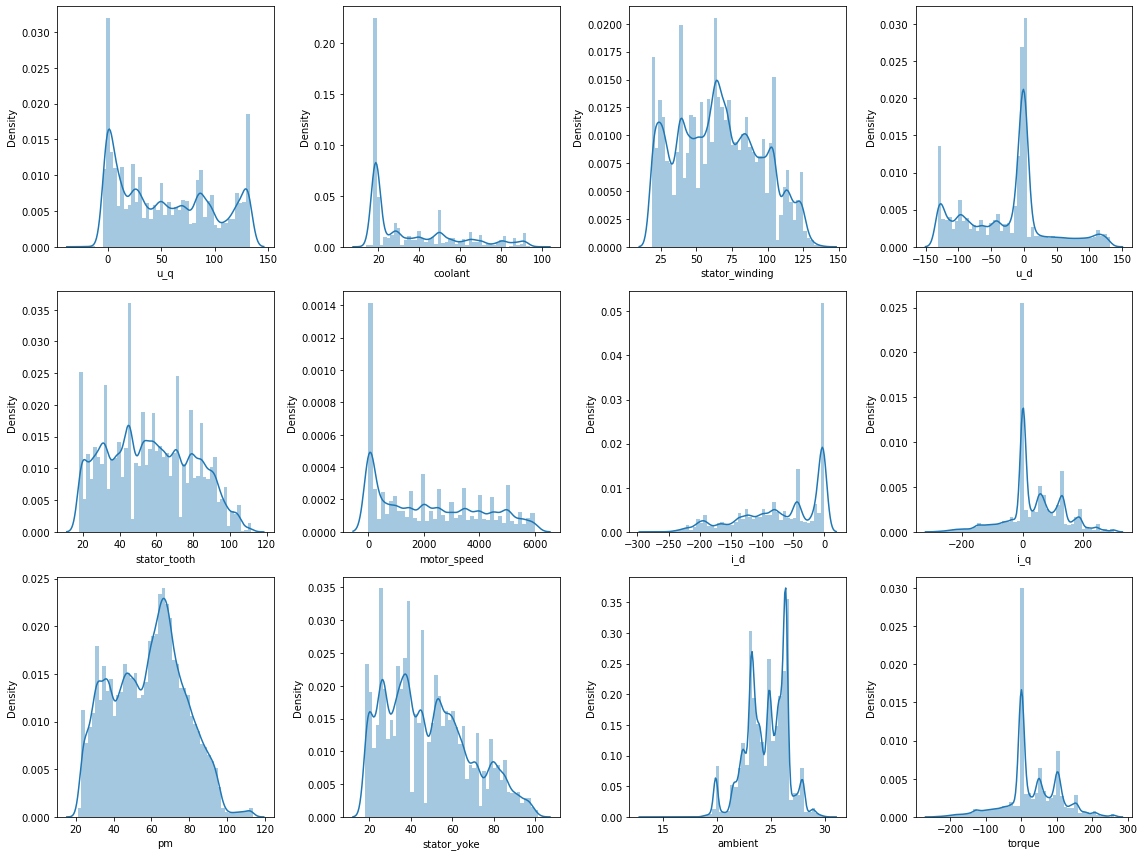

In [11]:
plt.figure(figsize=(16, 12))
for i in range(len(df2.columns)):
    plt.subplot(3, 4, i + 1)
    sns.distplot(df2[df2.columns[i]])
    plt.tight_layout()
plt.show()

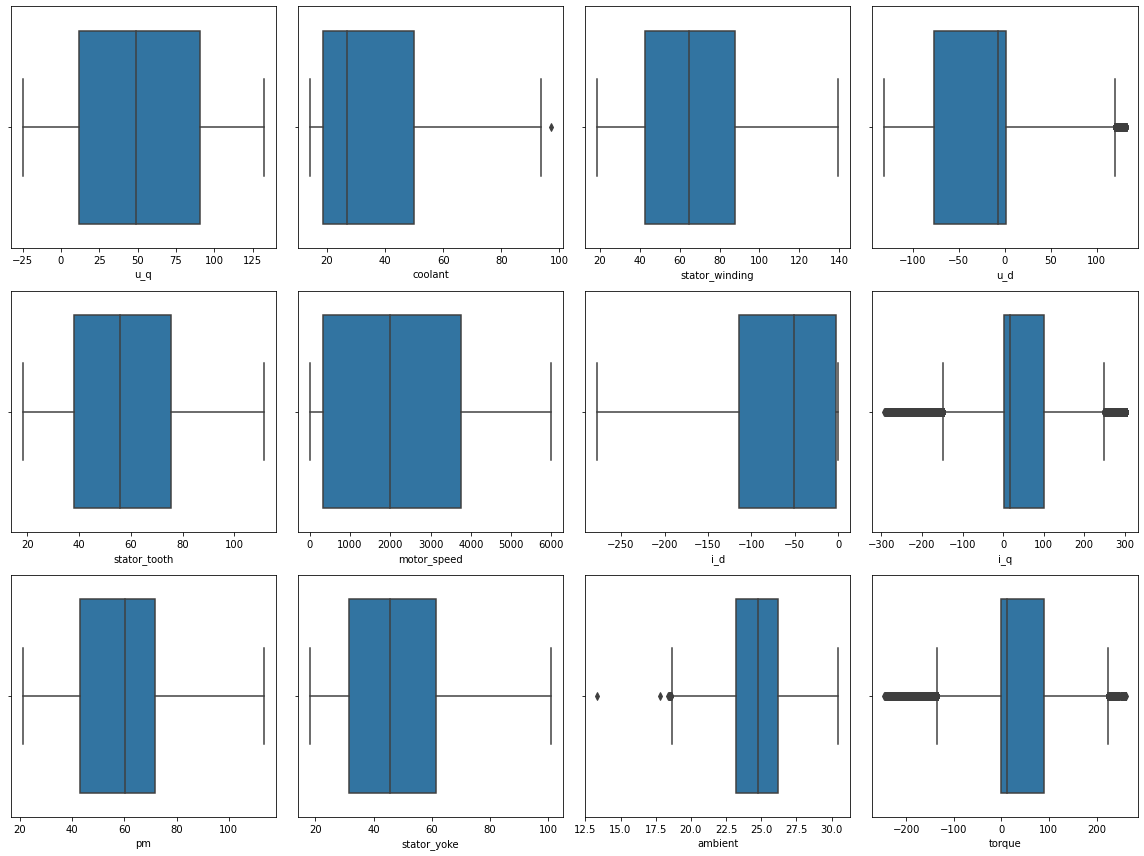

In [12]:
plt.figure(figsize=(16, 12))
for i in range(len(df2.columns)):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(df2[df2.columns[i]])
    plt.tight_layout()
plt.show()

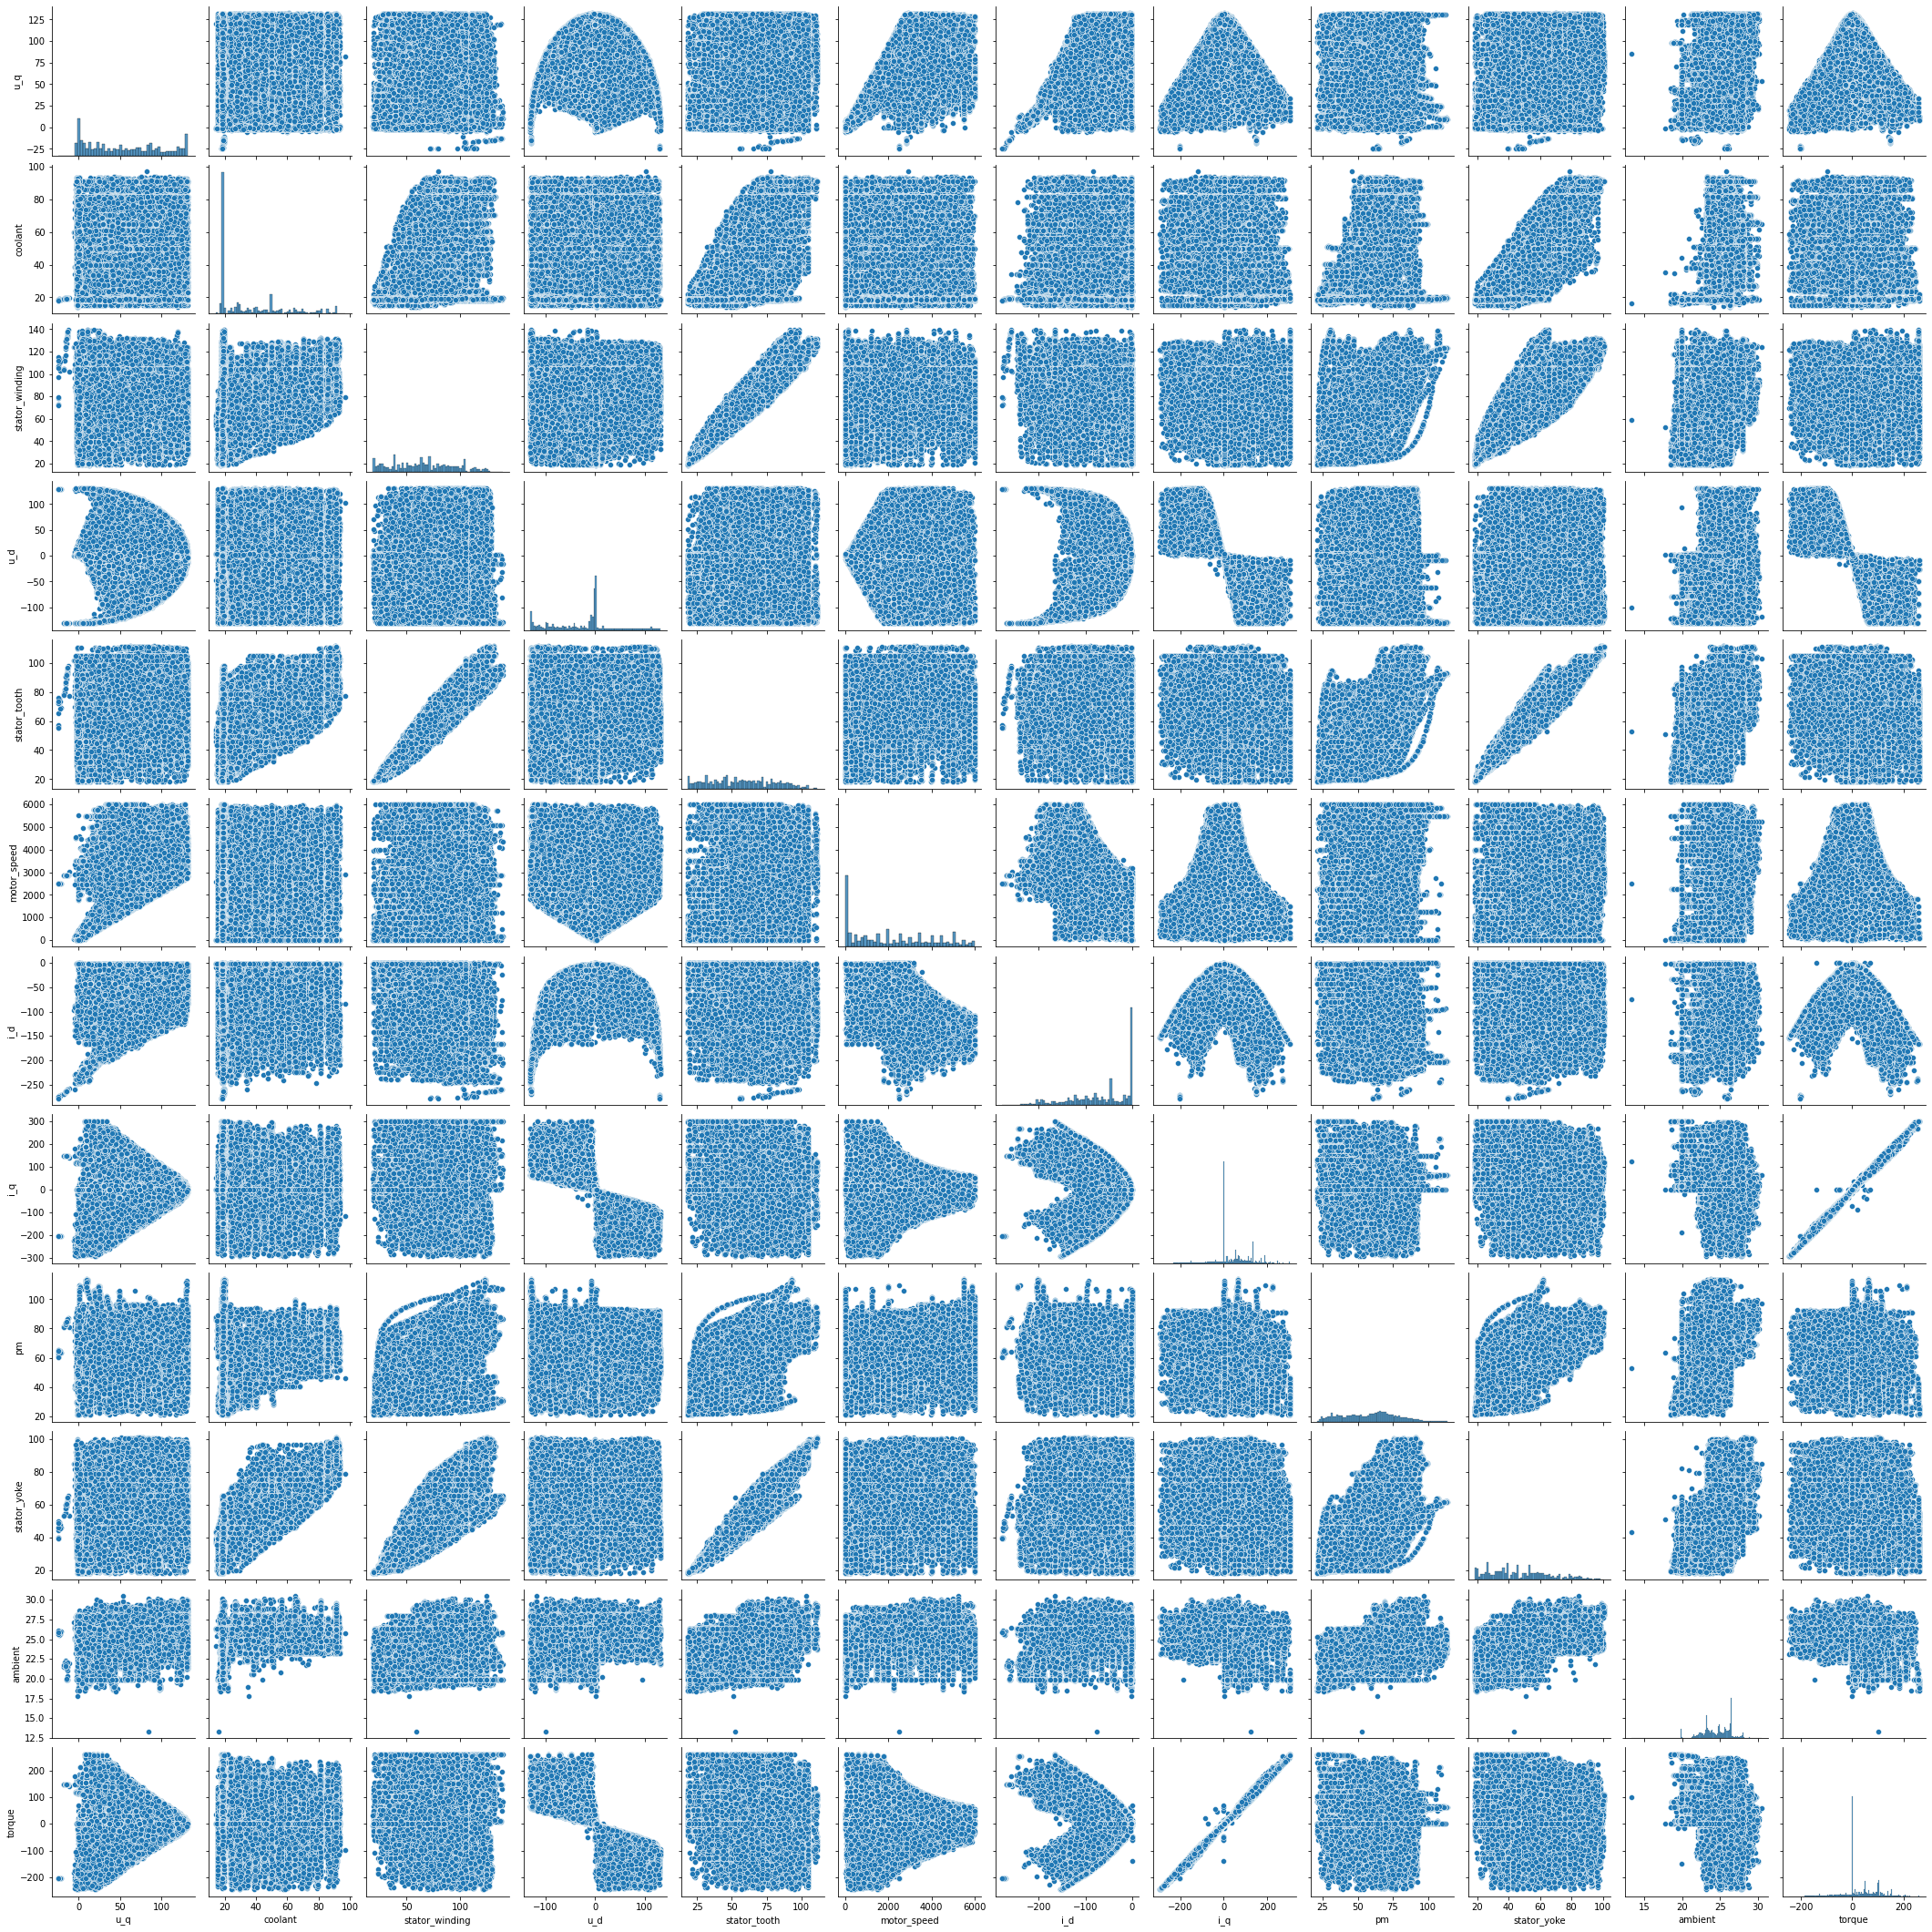

In [13]:
# Pairplot
sns.pairplot(df2)

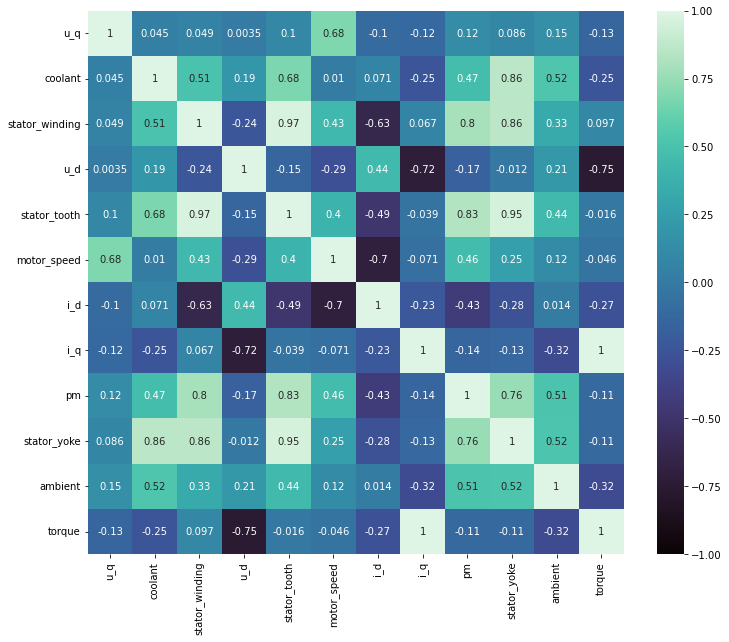

In [14]:
corr = df2.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.show()

In [15]:
# Output Of ANN Model
# Here We are considering the stator temperature as output.
y = df2.iloc[:,2]
y

200243      31.490210
1172416     72.127252
1100265     78.789772
902605     100.896531
253995      23.384708
              ...    
1109006     72.011824
651758      23.705139
507368     111.310875
370020      19.587341
641717      68.900466
Name: stator_winding, Length: 100000, dtype: float64

In [16]:
# Input of ANN Model
# Here we have 11 variables as input of our model
X =  df2.drop(["stator_winding"], axis = 'columns')
X

u_q    coolant         u_d  stator_tooth  motor_speed  \
200243   119.009178  18.276464   -1.046215     31.438330  2499.972900   
1172416  129.200774  49.726617  -25.127330     67.321840  3387.173849   
1100265   42.512333  33.197942  -99.614932     58.738952  1464.261623   
902605    -1.976776  78.930004    1.921546     93.918966     0.001570   
253995     1.155409  18.582739    0.160583     23.175192    -0.002007   
...             ...        ...         ...           ...          ...   
1109006   69.852906  49.770066   69.212882     64.522142  1850.675011   
651758    36.245626  23.605354   88.823153     21.647599  1438.301964   
507368    25.301832  18.351524 -128.507141     82.237869  5499.944336   
370020    12.032643  18.349010    0.837259     19.096033   250.002640   
641717    -0.250046  76.590809    3.180756     69.297547    -0.001545   

                i_d         i_q         pm  stator_yoke    ambient  \
200243    -1.999586    1.096891  44.646088    26.391846  25.626244   
1172416  -38.955149   18.620418  65.878021    59.956639  24.255000   
1100265 -122.971911  242.423959  40.154213    45.986175  22.958011   
902605    -2.001218    1.097614  79.113814    86.722261  25.982076   
253995    -0.001137    0.001262  68.244339    20.096991  25.423843   
...             ...         ...        ...          ...        ...   
1109006  -33.735372 -115.435830  73.211178    58.306154  24.805700   
651758   -98.992014 -227.235637  24.867818    21.671261  23.553992   
507368  -195.852737   66.423409  85.120941    55.368122  23.420513   
370020    -1.999926    1.098836  23.396156    18.842808  23.144619   
641717    -2.000436    1.096903  63.844787    71.196768  25.977263   

                torque  
200243   -8.749348e-01  
1172416   1.360481e+01  
1100265   2.000000e+02  
902605    7.492298e-07  
253995    5.304325e+00  
...                ...  
1109006  -8.753094e+01  
651758   -1.861304e+02  
507368    6.417290e+01  
370020    7.510241e-02  
641717  -4.402296e-189  

[100000 rows x 11 columns]

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size= 0.2, random_state = 0)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [19]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

In [20]:
## ANN Model
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units = 14,activation='relu'))
ann.add(tf.keras.layers.Dense(units = 14,activation='relu'))
ann.add(tf.keras.layers.Dense(units = 14,activation='relu'))
ann.add(tf.keras.layers.Dense(units = 14,activation='relu'))
ann.add(tf.keras.layers.Dense(units = 14,activation='relu'))
ann.add(tf.keras.layers.Dense(units = 14,activation='relu'))
ann.add(tf.keras.layers.Dense(units = 14,activation='relu'))
ann.add(tf.keras.layers.Dense(units = 1,activation='linear'))

opt = keras.optimizers.Adam(learning_rate=0.001)
ann.compile(optimizer = opt, loss = 'mse', metrics = ['accuracy'])

In [21]:
## training the model
history = ann.fit(X_train, y_train, batch_size = 50, epochs = 100)

Epoch 1/100
1280/1280 [==============================] - 3s 1ms/step - loss: 394.1620 - accuracy: 0.0000e+00: 0s - loss: 830.1657 - accu - ETA: 0s - loss: 560.5605 - accura - ETA: 0s - loss: 436.5933 - accuracy: 0.
Epoch 2/100
1280/1280 [==============================] - 2s 1ms/step - loss: 7.0830 - accuracy: 0.0000e+00: 0s - loss: 8.0705 - accuracy: 0. - ETA: 0s - loss: 7.7272 - accu - ETA: 0s - loss: 7.2132 - accuracy: 0.00
Epoch 3/100
1280/1280 [==============================] - ETA: 0s - loss: 4.7116 - accuracy: 0.0000e+00 ETA: 0s - loss: 4.7814 - accuracy:  - 2s 1ms/step - loss: 4.7006 - accuracy: 0.0000e+00
Epoch 4/100
1280/1280 [==============================] - 2s 1ms/step - loss: 3.8155 - accuracy: 0.0000e+00: 1s - loss: 4.0406  - ETA: 0s - loss: 3.951
Epoch 5/100
1280/1280 [==============================] - 2s 1ms/step - loss: 3.2926 - accuracy: 0.0000e+00: 1s - loss: 3.5588 - accuracy: 0.0000e+ - ETA: 1s - loss: 3.4815 - accura - ETA: 1s - loss: - ETA: 0s - loss: 3.3140 - ac

1280/1280 [==============================] - 2s 1ms/step - loss: 2.2624 - accuracy: 0.0000e+00: 1s - loss: 2.2741 - accuracy: 0.00 - ETA: 0s - loss: 2.2690 - accuracy:  - ETA: 0s - loss: 2.2662 - accu - ETA: 0s - loss: 2.2652 - accuracy: 0.0000
Epoch 40/100
1280/1280 [==============================] - 2s 1ms/step - loss: 2.2515 - accuracy: 0.0000e+00: 1s - loss: 2.3178 - accuracy - ETA: 1s - loss: 2.3124 - accuracy: 0. - ETA: 0s - loss: 2.2828 - accuracy - ETA: 0s - loss: 2.2770 - accuracy: 0.0000 - ETA: 0s - loss: 2.2639 - ac
Epoch 41/100
1280/1280 [==============================] - 2s 2ms/step - loss: 2.2399 - accuracy: 0.0000e+00
Epoch 42/100
1280/1280 [==============================] - 2s 1ms/step - loss: 2.2556 - accuracy: 0.0000e+00
Epoch 43/100
1280/1280 [==============================] - 2s 2ms/step - loss: 2.2232 - accuracy: 0.0000e+00: 1s - loss: 2.2 - ETA: 1s - l - ETA: 0s - loss: 2.2299 - accuracy: 0.00
Epoch 44/100
1280/1280 [==============================] - 2s 1ms/step -

1280/1280 [==============================] - 2s 2ms/step - loss: 2.0878 - accuracy: 0.0000e+00: 1s - loss: 2.0986 - accuracy - E - ETA: 0s - loss: 2.0844 - accuracy: 0. - ETA: 0s - loss: 2.0785 - accuracy: 0.0000e+ - ETA: 0s - loss: 2.0803 - accuracy: 0.
Epoch 88/100
1280/1280 [==============================] - 2s 2ms/step - loss: 2.1368 - accuracy: 0.0000e+00: 1s - loss: 2.1079 - accuracy - E - ETA: 0s - loss: 2.121
Epoch 89/100
1280/1280 [==============================] - 2s 2ms/step - loss: 2.1173 - accuracy: 0.0000e+00
Epoch 90/100
1280/1280 [==============================] - ETA: 0s - loss: 2.1500 - accuracy: 0.0000e+00 ETA: 1s - loss: 2.169 - ETA: 0s - loss: 2.1455 - ac - 2s 2ms/step - loss: 2.1507 - accuracy: 0.0000e+00
Epoch 91/100
1280/1280 [==============================] - 2s 2ms/step - loss: 2.0816 - accuracy: 0.0000e+00
Epoch 92/100
1280/1280 [==============================] - 2s 2ms/step - loss: 2.0837 - accuracy: 0.0000e+00: 0s - loss: 2.0981 - accura
Epoch 93/100
1280/1

In [22]:
y_pred =ann.predict(X_test)

In [23]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print(r2)

0.997159277425759


In [24]:
from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_test,y_pred))

MSE 2.332303637213087


In [25]:
from sklearn.metrics import mean_absolute_error
print("MAE",mean_absolute_error(y_test,y_pred))

MAE 1.103078911895003


In [26]:
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))

RMSE 1.527188147286734
